## Introduction

Artificial Intelligence has become an eminent part of automation in diverse domains. However, for the deployment of AI learning models in real life, AI still needs to overcome the “black box problem”. To tackle this problem, currently, AI researchers have dwelt in the field of eXplainable AI (XAI). The field of XAI aims to equip current AI learning models with transparency, fairness, accountability and explainability. Once these features have been fully developed, it will lead to Responsible AI, which can be used in practical cases of different fields.
Interpretability delineates the passive feature of a learning model referring to the extent at which a given learning model makes sense to a user.
Explainability is an active feature of a learning model describing the processes undertaken by the learning model with the intent of clarifying the inner working of the learning model. It is related to the notion of an argument or explanation where there is an interface between the user and the decision-maker.

### Dataset & Problem

We do prediction on the Santander Bank Customer Transaction dataset . In this challenge, we should help this bank  identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem. In this competition, The task is to predict the value of **target** column in the test set.

### Stages
1. Preprocessing & Exploratory Data analysis (EDA)
    - load and clean data
    - summary statistics
    - Plot target value counts and model class imbalance
2. Random Forest and Permutation Importance
    - fit random forest classifier to train set
    - permutation importance using eli5
3. Decision Tree and Partial Dependence Plots (PDP)
    - fit decison tree to test set
    - draw trees using graphviz
    - partial dependence plots using pdp
4. SHapley Additive exPlanations (SHAP)
    - Predict targets using RFC on test set
    - Extract and plot SHAP values using shap

### Imports

In [72]:
#Core
import numpy as np
import pandas as pd
import warnings
import time
import glob
import sys
import os
import gc

# Visualization
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp, get_dataset, info_plots
from IPython.display import display
import graphviz

# ML & AI

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import eli5
from eli5.sklearn import PermutationImportance
import shap
# from sklearn.svm import NuSVR
# from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve

### Setup

In [10]:
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

## Exploratory Data Analysis (EDA)

In [35]:
# Load data
train= pd.read_csv("../input/santander-customer-transaction-prediction-dataset/train.csv")
test = pd.read_csv("../input/santander-customer-transaction-prediction-dataset/test.csv")

In [15]:
train.head(5)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.953600000000000,9.4292,11.432700000000001,-2.380500000000000,5.8493,18.267499999999998,2.1337,...,-2.1556,11.849500000000001,-1.4300,2.4508,13.711200000000000,2.4669,4.3654,10.720000000000001,15.472200000000001,-8.719700000000000
1,test_1,8.5304,1.2543,11.304700000000000,5.1858,9.197400000000000,-4.011700000000000,6.0196,18.631599999999999,-4.4131,...,10.6165,8.834899999999999,0.9403,10.1282,15.576499999999999,0.4773,-1.4852,9.871400000000000,19.129300000000001,-20.975999999999999
2,test_2,5.4827,-10.3581,10.140700000000001,7.0479,10.262800000000000,9.805199999999999,4.8950,20.253699999999998,1.5233,...,-0.7484,10.993499999999999,1.9803,2.1800,12.981299999999999,2.1281,-7.1086,7.061800000000000,19.895600000000002,-23.179400000000001
3,test_3,8.5374,-1.3222,12.022000000000000,6.5749,8.845800000000001,3.174400000000000,4.9397,20.565999999999999,3.3755,...,9.5702,9.076599999999999,1.6580,3.5813,15.187400000000000,3.1656,3.9567,9.229500000000000,13.016800000000000,-4.210800000000000
4,test_4,11.7058,-0.1327,14.129500000000000,7.7506,9.103500000000000,-8.584800000000000,6.8595,10.604799999999999,2.9890,...,4.2259,9.172300000000000,1.2835,3.3778,19.554200000000002,-0.2860,-5.1612,7.288200000000000,13.926000000000000,-9.184600000000000


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


In [32]:
train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,10.658737106499814,-1.624243780000001,10.707451979500098,6.788213908500028,11.076399133000201,-5.050557728999840,5.415164112499948,16.529142737500187,0.277134826000005,7.569407457999987,...,3.189766290500038,7.458269406000029,1.925944148000011,3.322015686499963,17.996966971999775,-0.133656945500000,2.290898700500025,8.912428147499998,15.869183606499927,-3.246341973000006
std,3.036715580819891,4.040509145134395,2.633888454459103,2.052723659414844,1.616456202024966,7.869293010371570,0.864686131639427,3.424481815614266,3.333374933609618,1.231865473138074,...,4.551239144908742,3.025189353414047,1.479966003195186,3.995598711971345,3.140652495578780,1.429678194738301,5.446345508745113,0.920904306663015,3.008717108209617,10.398588894115639
min,0.188700000000000,-15.043400000000000,2.355200000000000,-0.022400000000000,5.484400000000000,-27.766999999999999,2.216400000000000,5.713700000000000,-9.956000000000000,4.243300000000000,...,-14.093299999999999,-2.407000000000000,-3.340900000000000,-11.413100000000000,9.382800000000000,-4.911900000000000,-13.944200000000000,6.169600000000000,6.584000000000000,-39.457799999999999
25%,8.442975000000001,-4.700125000000000,8.735600000000000,5.230500000000000,9.891075000000001,-11.201400000000000,4.772600000000000,13.933900000000000,-2.303900000000000,6.623800000000000,...,-0.095000000000000,5.166500000000000,0.882975000000000,0.587600000000000,15.634775000000001,-1.160700000000000,-1.948600000000000,8.260075000000001,13.847275000000000,-11.124000000000001
50%,10.513800000000000,-1.590500000000000,10.560700000000001,6.822350000000000,11.099750000000000,-4.834100000000000,5.391600000000000,16.422699999999999,0.372000000000000,7.632000000000000,...,3.162400000000000,7.379000000000000,1.892600000000000,3.428500000000000,17.977599999999999,-0.162000000000000,2.403600000000000,8.892799999999999,15.943400000000000,-2.725950000000000
75%,12.739599999999999,1.343400000000000,12.495025000000000,8.327600000000000,12.253399999999999,0.942575000000000,6.005800000000000,19.094549999999998,2.930025000000000,8.584824999999999,...,6.336475000000000,9.531100000000000,2.956000000000000,6.174200000000000,20.391725000000001,0.837900000000000,6.519800000000000,9.595900000000000,18.045200000000001,4.935400000000000
max,22.323399999999999,9.385100000000000,18.714099999999998,13.141999999999999,16.037099999999999,17.253699999999998,8.302500000000000,28.292800000000000,9.665500000000000,11.003600000000000,...,20.359000000000002,16.716500000000000,8.005000000000001,17.632600000000000,27.947800000000001,4.545400000000000,15.920700000000000,12.275800000000000,26.538399999999999,27.907399999999999


### Visualization

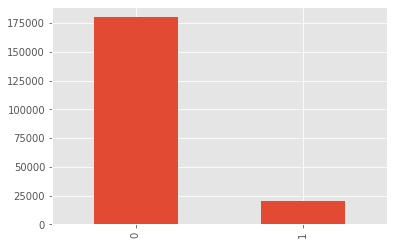

In [36]:
# Target value counts
train.target.value_counts().plot.bar();

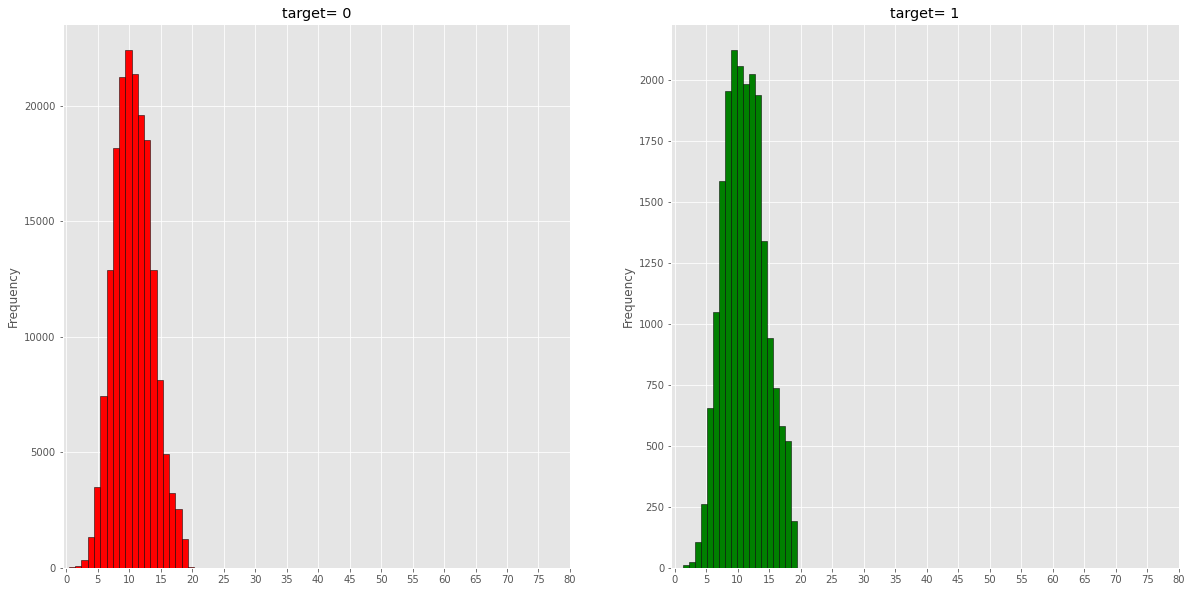

In [37]:
# Hist of target frequencies
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

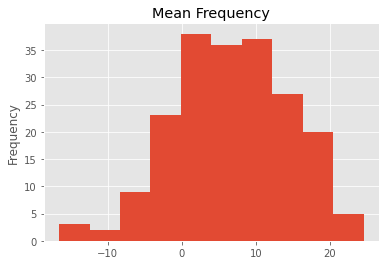

In [39]:
train[train.columns[2:]].mean().plot(kind='hist');plt.title('Mean Frequency');

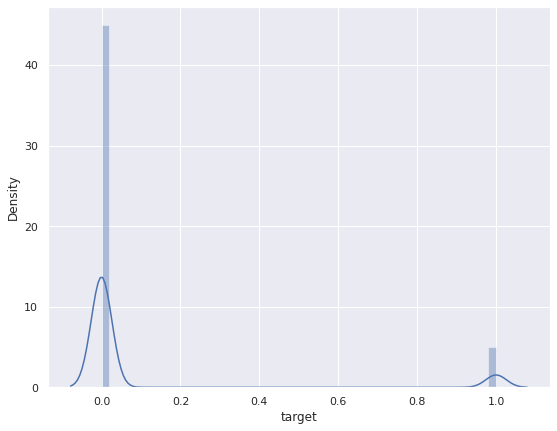

In [44]:
# Distplot to model class imbalance
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

In [48]:
# Check for missing data
train.isna().mean()

False

In [49]:
test.isna().mean()

False

In [51]:
# Class imbalance
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [56]:
# Prep data
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]
X_test  = test.drop("ID_code",axis=1)

In [57]:
# Random Forest
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

## Explainability

### Permutation Importance
 In this section we will answer following question:
 1. What features have the biggest impact on predictions?
 2. How to extract insights from models?

In [59]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [61]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.0000 ± 0.0000,var_99
0.0000 ± 0.0000,var_184
0.0000 ± 0.0000,var_174
0.0000 ± 0.0000,var_166
0.0000 ± 0.0000,var_154
0.0000 ± 0.0000,var_12
0.0000 ± 0.0000,var_133
0.0000 ± 0.0000,var_145
0.0000 ± 0.0000,var_1
0.0000 ± 0.0000,var_140


### Analysis
- As you move down the top of the graph, the importance of the feature decreases.
- The features that are shown in green indicate that they have a positive impact on our prediction
- The features that are shown in white indicate that they have no effect on our prediction
- The features shown in red indicate that they have a negative impact on our prediction

### Partial Dependence Plots
Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

In [62]:
# Decision Tree
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [63]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [66]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

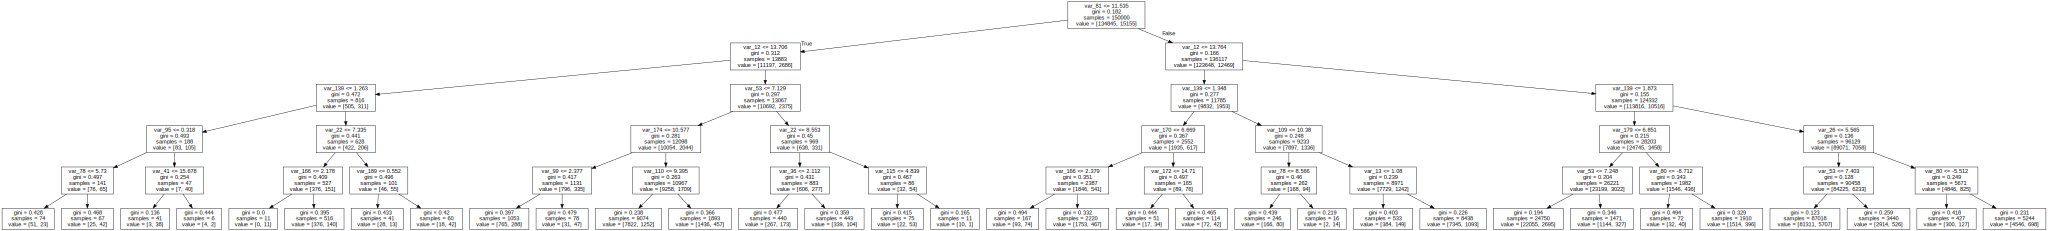

In [67]:
graphviz.Source(tree_graph)

- Leaves with children show their splitting criterion on the top
- The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.

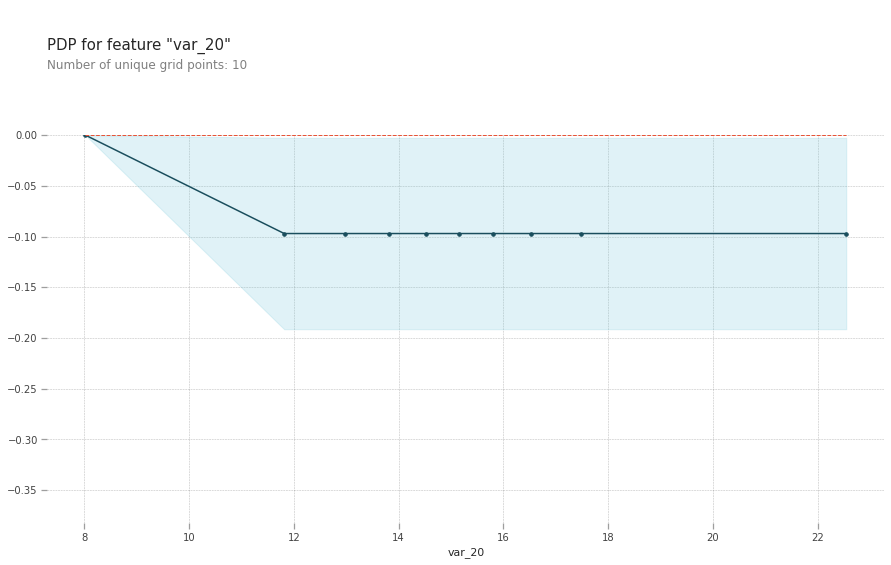

In [68]:
# Create pdp
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_20')
pdp.pdp_plot(pdp_goals, 'var_20')
plt.show()

- The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

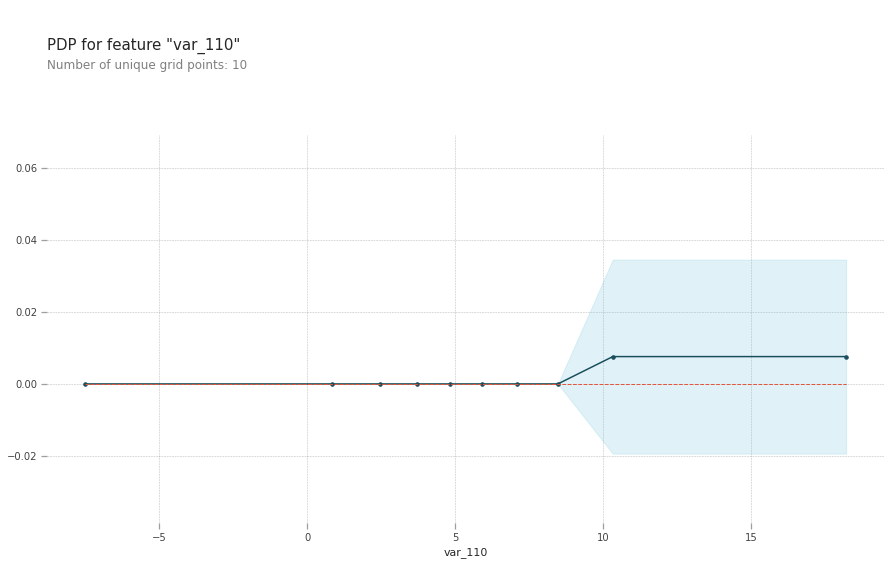

In [70]:
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

### SHAP
SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the SHAP NIPS paper for details).

In [71]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use multiple?
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rfc_model.predict_proba(data_for_prediction_array);

In [77]:
# Create shap object
explainer = shap.TreeExplainer(rfc_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction, check_additivity=False)

In [78]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)